# KNN_16QAM Modulation

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sofa_sem import *

In [38]:
warnings.filterwarnings("ignore", category=FutureWarning)

## Generación y modulacion de los datos

In [39]:
Ns = 100000
Mod = 16 #16QAM
symbols_tx = np.random.randint(Mod, size=Ns)
df = pd.DataFrame()
df['tx'] = symbols_tx
df.head()

,tx
0,3
1,7
2,13
3,9
4,3


In [40]:
# Diccionario con el que se modulan los datos
mod_dict = {0:-3+3j, #0000
            1:-3+1j, #0001
            2:-3-3j, #0010
            3:-3-1j, #0011
            4:-1+3j, #0100
            5:-1+1j, #0101
            6:-1-3j, #0110
            7:-1-1j, #0111
            8:3+3j,  #1000
            9:3+1j,  #1001
            10:3-3j, #1010
            11:3-1j, #1011
            12:1+3j, #1100
            13:1+1j, #1101
            14:1-3j, #1110
            15:1-1j} #1111

In [41]:
# Modulación de los datos
df_tx = df.replace(mod_dict)
df_tx.head()

,tx
0,-3.0-1.0j
1,-1.0-1.0j
2,1.0+1.0j
3,3.0+1.0j
4,-3.0-1.0j


## Adición de ruido AWGN para simular un canal real

In [42]:
Xr = np.real(df_tx['tx'])
Xi = np.imag(df_tx['tx'])

In [43]:
# Se generan varias intensidades de ruido AWGN y se agregan a los datos
target_snr_db = [i for i in np.arange(4, 25, 4)]
Xr_ch = [add_noise(Xr, i) for i in target_snr_db]
Xi_ch = [add_noise(Xi, i) for i in target_snr_db]

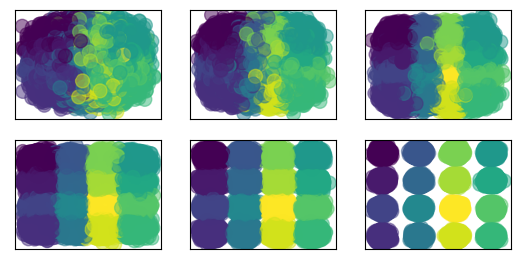

In [44]:
# Grafica de los datos extraidos del canal
for i in range(len(target_snr_db)):
    plt.subplot(3, 3, i + 1)
    plt.scatter(Xr_ch[i], Xi_ch[i], c=df['tx'], s=100, marker='o', alpha=0.5)
    plt.xticks(())
    plt.yticks(())
plt.show()

## Demodulación convencional

In [45]:
# Se demapean los datos extraidos del canal con ruido
sym_rx = [demapper_sym(Xr_ch[i], Xi_ch[i], len(Xr_ch[i]), threshold = 2.0) for i in range(len(target_snr_db))]

In [46]:
ser_conventional = []
for i in range(len(target_snr_db)):
  ser, ser_error = symbol_error_rate(df['tx'], sym_rx[i])
  ser_conventional.append(ser)

In [47]:
ber_conventional = []
for i in range(len(target_snr_db)):
  ber, ber_error = bit_error_rate(df['tx'], sym_rx[i])
  ber_conventional.append(ber)

## Demodulación usando el algoritmo KNN

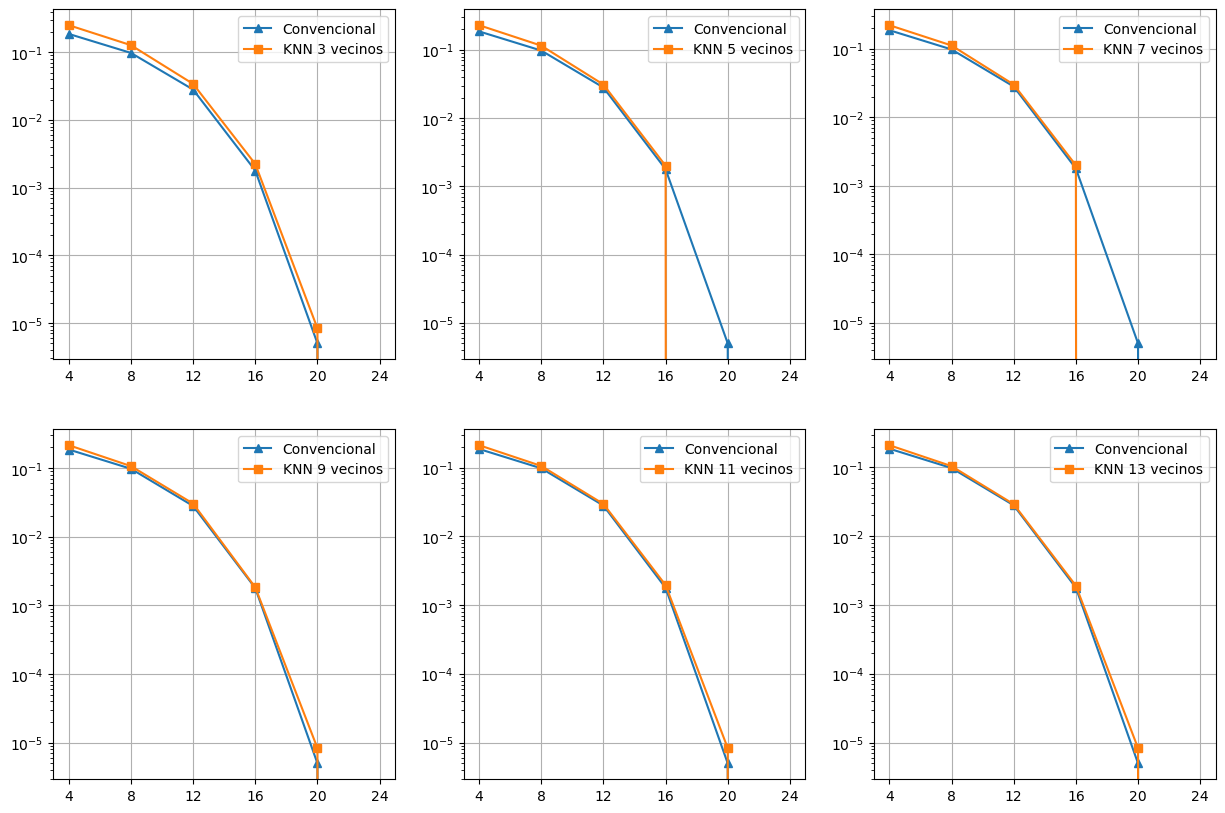

In [48]:
plt.figure(figsize=(15,10))
for k_it, k in enumerate([3, 5, 7, 9, 11, 13]):
    ser_knn = []
    ber_knn = []
    for it, item in enumerate(target_snr_db):
        X = np.transpose(np.array([Xr_ch[it], Xi_ch[it]]))
        y = df['tx']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

        model = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)

        y_pred = model.predict(X_test)


        ber, ber_error = bit_error_rate(y_test, y_pred)
        ber_knn.append(ber)

    plt.subplot(2, 3, k_it + 1)
    plt.plot(target_snr_db, ber_conventional, marker='^', label='Convencional')
    plt.plot(target_snr_db, ber_knn, marker='s', label=f'KNN {k} vecinos')
    plt.yscale('log')
    plt.xticks(target_snr_db)
    plt.grid()
    plt.legend()

plt.show()